In [58]:
import os
import pandas as pd
import numpy as np
import duckdb

from tbparse import SummaryReader

os.chdir('/home/scur2012/Thesis/master-thesis/final_peregrine_runs/results')

In [59]:
names = dict(
    unet = "UNet_original_2",
    #unet2 = "",
    unet_attention = "AttentionUNet_2",
    unet_half = "UNet_original_half",
    #unet_pruned0 = "UNet_pruned0",
    unet_pruned5 = "UNet_pruned5",
    unet_pruned10 = "UNet_pruned10",
    #vit = "ViT",
    vit_pretrained = "ViT_pretrained_2",
    unet_noreinit = "UNet_NoReinit",
    unet_softloss = "UNet_Softloss",
)


In [60]:
import math
def calc_rel_integral(row):
    
    if row['Parameter'] in ['theta_jn', 'tilt_1', 'tilt_2']:
        return -math.cos(row[1]) + math.cos(row[0])
    elif row['Parameter'] ==  'dec':
        return math.sin(row[1]) - math.sin(row[0])    
    elif row['Parameter'] ==  'luminosity_distance':
        return (5.73E-07*row[1]**2 -1.22E-04*row[1]) - (5.73E-07*row[0]**2 -1.22E-04*row[0])
    else:
        return (row[1] - row[0])


# Set up dataframe to store bounds in
bounds_prior = pd.read_table(f'priors.txt', sep=',', header=None, index_col=None)
bounds_prior.columns = ['Parameter', 0, 1]

bounds_prior['prior_range'] = bounds_prior.apply(calc_rel_integral,axis=1).values
bounds_range = bounds_prior.drop(columns=[0,1])

df_all = pd.DataFrame(columns=['network', 'round', 'step', 'tag', 'value'])

offset=0 # 1 = take fraction at beginning of round. 0 = take fraction at end.

for k,v in names.items():
    
    bounds_range[f'{k}_{1}'] = bounds_prior['prior_range']
    
    for rnd_id in range(1,9):
            
        try:
            bounds = pd.read_table(f'tb_logs/{v}/bounds_{v}_R{rnd_id}.txt', sep='\\s+', header=None)
            bounds['Parameter'] = bounds_prior['Parameter']
            
            try:
                pd.read_table(f'tb_logs/{v}/bounds_{v}_R{rnd_id+offset}.txt')
            except FileNotFoundError:
                continue
            finally:
                bounds_range[f'{k}_{rnd_id+offset}'] = bounds.apply(calc_rel_integral,axis=1).values
            
            df = SummaryReader(f'tb_logs/{v}/R{rnd_id}').scalars
            df['round'] = rnd_id
            df['network'] = k
            
            df_all = pd.concat([df_all, df])
            
        except FileNotFoundError:
            continue

bounds_range = bounds_range.set_index('Parameter')
product_row = bounds_range.prod()
bounds_range.loc['product'] = product_row
bounds_range.loc['fraction'] = product_row/product_row['prior_range']
print (bounds_range.to_string())

/scratch-local/scur2012/ipykernel_4080438/710141572.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


                      prior_range        unet_1      unet_2    unet_3    unet_4    unet_5        unet_6        unet_7        unet_8  unet_attention_1  unet_attention_2  unet_attention_3  unet_attention_4  unet_attention_5  unet_attention_6  unet_attention_7  unet_attention_8   unet_half_1   unet_half_2  unet_half_3  unet_half_4  unet_half_5  unet_half_6  unet_half_7  unet_half_8  unet_pruned5_1  unet_pruned5_2  unet_pruned5_3  unet_pruned5_4  unet_pruned5_5  unet_pruned5_6  unet_pruned5_7  unet_pruned10_1  unet_pruned10_2  unet_pruned10_3  unet_pruned10_4  unet_pruned10_5  unet_pruned10_6  unet_pruned10_7  unet_pruned10_8  vit_pretrained_1  vit_pretrained_2  vit_pretrained_3  unet_noreinit_1  unet_noreinit_2  unet_noreinit_3  unet_noreinit_4  unet_noreinit_5  unet_noreinit_6  unet_noreinit_7  unet_noreinit_8  unet_softloss_1  unet_softloss_2  unet_softloss_3  unet_softloss_4  unet_softloss_5  unet_softloss_6  unet_softloss_7  unet_softloss_8
Parameter                                   

In [61]:
bounds_range.iloc[:,1:] = bounds_range.iloc[:,1:].values / bounds_range.iloc[:,0:1].values
bounds_range

,prior_range,unet_1,unet_2,unet_3,unet_4,unet_5,unet_6,unet_7,unet_8,unet_attention_1,...,unet_noreinit_7,unet_noreinit_8,unet_softloss_1,unet_softloss_2,unet_softloss_3,unet_softloss_4,unet_softloss_5,unet_softloss_6,unet_softloss_7,unet_softloss_8
Parameter,,,,,,,,,,,,,,,,,,,,,
mass_ratio,8.750000e-01,0.999991,0.910668,0.903379,0.887175,0.806950,8.069310e-01,8.069228e-01,7.648382e-01,0.999987,...,7.674442e-01,7.638054e-01,0.999978,0.999947,0.846546,0.746611,0.746606,0.746597,0.746590,0.746578
chirp_mass,7.500000e+01,0.270958,0.165569,0.100371,0.088280,0.088278,8.473879e-02,8.473440e-02,8.271243e-02,0.245662,...,7.532377e-02,7.532038e-02,0.280078,0.172326,0.109409,0.088026,0.084739,0.078119,0.078118,0.077761
theta_jn,2.000000e+00,0.999988,0.567483,0.419179,0.389774,0.389767,3.751479e-01,3.751387e-01,3.751364e-01,0.745143,...,3.222357e-01,3.190625e-01,0.999970,0.545158,0.468831,0.425315,0.425312,0.425311,0.425282,0.425265
phase,6.283180e+00,0.999967,0.999924,0.999909,0.999897,0.999860,9.998146e-01,9.997991e-01,9.997936e-01,0.999993,...,9.998207e-01,9.997657e-01,0.999993,0.999959,0.999946,0.999931,0.999897,0.999873,0.999868,0.999853
tilt_1,2.000000e+00,0.999992,0.999950,0.999941,0.999937,0.999914,9.998909e-01,9.998711e-01,9.998464e-01,0.999968,...,9.998276e-01,9.997680e-01,0.999992,0.999974,0.999961,0.999950,0.999920,0.999910,0.999886,0.999866
tilt_2,2.000000e+00,0.999978,0.999968,0.999930,0.999902,0.999877,9.998471e-01,9.998099e-01,9.997656e-01,0.999984,...,9.998372e-01,9.998270e-01,0.999989,0.999968,0.999962,0.999946,0.999918,0.999912,0.999886,0.999862
a_1,9.500000e-01,0.999998,0.999997,0.999990,0.999969,0.999935,9.999209e-01,9.999095e-01,9.999018e-01,0.999981,...,9.998869e-01,9.998856e-01,0.999976,0.999953,0.999879,0.999862,0.999850,0.999830,0.999788,0.999756
a_2,9.500000e-01,0.999989,0.999936,0.999882,0.999878,0.999851,9.998340e-01,9.998231e-01,9.998091e-01,0.999991,...,9.999077e-01,9.998852e-01,0.999995,0.999982,0.999942,0.999935,0.999927,0.999892,0.999875,0.999866
phi_12,6.283180e+00,0.999963,0.999927,0.999878,0.999858,0.999853,9.998372e-01,9.998320e-01,9.998114e-01,0.999985,...,9.998460e-01,9.998142e-01,0.999937,0.999928,0.999922,0.999911,0.999865,0.999844,0.999841,0.999828


In [62]:
# Query to select the highest training step for each round and each network

query = """
    SELECT t1.network, t1.round, t1.step, 
    CASE 
        WHEN t1.tag LIKE 'val_loss_feature%' THEN 'feature_loss'
        WHEN t1.tag LIKE 'val_auc_feature%' THEN 'feature_auc'
        ELSE t1.tag
        END AS metric,    
        t1.tag, t1.value
    FROM df_all t1
    INNER JOIN (
        SELECT network, round, tag, MAX(step) AS max_step
        FROM df_all
        GROUP BY network, round, tag
    ) t2 ON t1.network = t2.network AND t1.round = t2.round AND t1.tag = t2.tag AND t1.step = t2.max_step
    WHERE t1.tag IN ('epoch', 'train_loss', 'test_loss') OR t1.tag LIKE 'val_loss_feature%' OR t1.tag LIKE 'val_auc_feature%'
    ;
"""

with duckdb.connect(database=':memory:') as conn:
    df_max_step = conn.execute(query).df()
df_max_step

,network,round,step,metric,tag,value
0,unet_softloss,5,25019,feature_auc,val_auc_feature_12,0.877810
1,unet_softloss,5,25019,feature_loss,val_loss_feature_8,0.087229
2,unet_softloss,6,39299,feature_auc,val_auc_feature_11,0.872759
3,unet_softloss,6,39299,feature_auc,val_auc_feature_2,0.829630
4,unet_softloss,6,39299,feature_auc,val_auc_feature_6,0.724517
...,...,...,...,...,...,...
1909,unet_half,4,17471,feature_auc,val_auc_feature_10,0.791639
1910,unet_half,5,12064,test_loss,test_loss,-4.250677
1911,unet_softloss,2,11439,feature_loss,val_loss_feature_5,-0.015113
1912,unet_pruned5,4,20015,feature_loss,val_loss_feature_4,-0.232513


In [63]:
# Query to aggregate the paramater metrics and sort table

query = """
    SELECT network, round, metric, 
        CASE
            WHEN metric = 'feature_loss' THEN SUM(value)
            WHEN metric = 'feature_auc' THEN AVG(value)
            ELSE FIRST(value)
        END as agg_value,
        CASE 
            WHEN network = 'unet' THEN 1
            WHEN network = 'unet_noreinit' THEN 2
            WHEN network = 'unet_half' THEN 3
            WHEN network = 'unet_attention' THEN 4
            WHEN network = 'unet_pruned5' THEN 5
            WHEN network = 'unet_pruned10' THEN 6
            WHEN network = 'vit_pretrained' THEN 7
            WHEN network = 'unet_softloss' THEN 8
            
        END AS sorter
    
    FROM df_max_step
    GROUP BY network, round, metric
    ORDER BY sorter, round, metric
    ;
"""

with duckdb.connect(database=':memory:') as conn:
    df_avg = conn.execute(query).df()
print(df_avg.to_string())

            network  round        metric   agg_value  sorter
0              unet      1         epoch   57.000000       1
1              unet      1   feature_auc    0.701485       1
2              unet      1  feature_loss   -4.062866       1
3              unet      1     test_loss   -4.032083       1
4              unet      1    train_loss   -4.001183       1
5              unet      2         epoch  115.000000       1
6              unet      2   feature_auc    0.717572       1
7              unet      2  feature_loss   -4.212302       1
8              unet      2     test_loss   -4.240633       1
9              unet      2    train_loss   -4.486412       1
10             unet      3         epoch   80.000000       1
11             unet      3   feature_auc    0.742866       1
12             unet      3  feature_loss   -4.737814       1
13             unet      3     test_loss   -4.713381       1
14             unet      3    train_loss   -4.573666       1
15             unet     

In [64]:
num_steps = df_max_step[df_max_step['tag']=='epoch']

df_pivot_avg = df_avg.pivot_table(index=['sorter','network', 'round'], columns='metric', values='agg_value', aggfunc='first').reset_index()
df_pivot_avg['fraction'] = bounds_range.iloc[-1,1:].values
df_pivot_steps = df_pivot_avg.merge(num_steps[['network', 'round', 'step']], how='left', on=['network', 'round'])


In [65]:
network_names = dict(
    unet = "U-Net",
    unet_half = "U-Net (half)",
    unet_attention = "Att U-Net",
    #unet_pruned0 = "UNet_pruned0",
    unet_pruned5 = "U-Net 5\\%",
    unet_pruned10 = "U-Net 10\\%",
    #vit = "ViT",
    vit_pretrained = "ViT",
    unet_noreinit = "U-Net (NR)",
    unet_softloss = "U-Net (Softloss)",
)

column_names = dict(
    network = "Network",
    round = "Round",
    epoch = "Num Epochs",
    step = "Num Steps",
    fraction = "Truncation Fraction",
    train_loss = "Train Loss",
    test_loss = "Test Loss",
    feature_auc = "Avg AUROC",
    Runtime = "Runtime",
)

df_fin = df_pivot_steps[['network', 'round', 'epoch', 'step', 'fraction', 'train_loss', 'test_loss', 'feature_auc']].copy()
#df_fin['Runtime'] = 0

df_fin['epoch'] = df_fin['epoch'].astype('int')
df_fin['fraction'] = df_fin['fraction'].astype('float').map('{:,.2e}'.format)
df_fin['train_loss'] = df_fin['train_loss'].astype('float').map('{:,.2f}'.format)
df_fin['test_loss'] = df_fin['test_loss'].astype('float').map('{:,.2f}'.format)
df_fin['feature_auc'] = df_fin['feature_auc'].astype('float').map('{:,.3f}'.format)

df_fin['network'] = df_fin['network'].replace(network_names)
df_fin = df_fin.rename(columns=column_names)

print (
    df_fin.to_latex(
        bold_rows=True, 
        index=False, 
        multicolumn=True,
        caption='Comparison of different network architectures for Peregrine', 
        label='tab:peregrine_network_comparisons'
    )
)

\begin{table}
\caption{Comparison of different network architectures for Peregrine}
\label{tab:peregrine_network_comparisons}
\begin{tabular}{lrrrllll}
\toprule
Network & Round & Num Epochs & Num Steps & Truncation Fraction & Train Loss & Test Loss & Avg AUROC \\
\midrule
U-Net & 1 & 57 & 5757 & 4.47e-02 & -4.00 & -4.03 & 0.701 \\
U-Net & 2 & 115 & 23920 & 2.04e-04 & -4.49 & -4.24 & 0.718 \\
U-Net & 3 & 80 & 24720 & 6.33e-06 & -4.57 & -4.71 & 0.743 \\
U-Net & 4 & 70 & 29190 & 2.13e-06 & -4.71 & -4.61 & 0.747 \\
U-Net & 5 & 44 & 18348 & 1.61e-06 & -4.09 & -4.10 & 0.735 \\
U-Net & 6 & 80 & 41920 & 9.33e-07 & -4.39 & -4.39 & 0.742 \\
U-Net & 7 & 45 & 23580 & 9.29e-07 & -4.68 & -4.33 & 0.739 \\
U-Net & 8 & 108 & 56592 & 7.29e-07 & -4.76 & -4.54 & 0.746 \\
U-Net (NR) & 1 & 61 & 6161 & 3.07e-03 & -4.36 & -3.98 & 0.700 \\
U-Net (NR) & 2 & 55 & 11440 & 1.18e-05 & -4.30 & -4.03 & 0.709 \\
U-Net (NR) & 3 & 65 & 20085 & 7.70e-06 & -4.68 & -4.59 & 0.734 \\
U-Net (NR) & 4 & 52 & 21684 & 4.98e-06 & 

In [66]:
df_max_step

,network,round,step,metric,tag,value
0,unet_softloss,5,25019,feature_auc,val_auc_feature_12,0.877810
1,unet_softloss,5,25019,feature_loss,val_loss_feature_8,0.087229
2,unet_softloss,6,39299,feature_auc,val_auc_feature_11,0.872759
3,unet_softloss,6,39299,feature_auc,val_auc_feature_2,0.829630
4,unet_softloss,6,39299,feature_auc,val_auc_feature_6,0.724517
...,...,...,...,...,...,...
1909,unet_half,4,17471,feature_auc,val_auc_feature_10,0.791639
1910,unet_half,5,12064,test_loss,test_loss,-4.250677
1911,unet_softloss,2,11439,feature_loss,val_loss_feature_5,-0.015113
1912,unet_pruned5,4,20015,feature_loss,val_loss_feature_4,-0.232513


In [67]:
# Round 8: results per parameter

intrinsic_variables = ['mass_ratio', 'chirp_mass', 'theta_jn', 'phase', 'tilt_1', 'tilt_2', 'a_1', 'a_2', 'phi_12', 'phi_jl']
extrinsic_variables = ['luminosity_distance', 'dec', 'ra', 'psi', 'geocent_time']

latex_params = [r'$q$', r'$M$', r'$\theta_{jn}$', r'$\phi_c$', r'$\theta_1$', r'$\theta_2$', r'$a_1$', r'$a_2$', r'$\phi_{12}$', r'$\phi_{jl}$', r'$d_L$', r'$\delta$', r'$\alpha$', r'$\psi$', r'$t_c$']

name_dict = dict(zip(intrinsic_variables+extrinsic_variables, latex_params))

rnd_id = 7

query = f"""
    WITH roundi AS (
        SELECT network, metric,
            CASE 
                {" ".join([f"WHEN df.tag LIKE 'val_%_feature_{i}' THEN '{name}'" for i,name in enumerate(
                    intrinsic_variables+extrinsic_variables)])}
            END AS feature,
            value
                
        FROM df_max_step df
        WHERE (df.metric = 'feature_auc' OR df.metric = 'feature_loss')
            AND round = {rnd_id}
    )
    PIVOT roundi
    ON metric, network
    USING FIRST(value)
    """

with duckdb.connect(database=':memory:') as conn:
    df_val = conn.execute(query).df()

df_valpp = df_val.set_index('feature').loc[intrinsic_variables+extrinsic_variables].round(3)
df_valpp.index = latex_params

In [68]:
columns = ['feature_auc_unet','feature_auc_unet_noreinit','feature_auc_unet_attention', 'feature_auc_unet_pruned5', 'feature_auc_unet_pruned10']
print (df_valpp.loc[:,columns].to_latex(float_format='%.3f', caption='Round 8 AUC and loss values'))

\begin{table}
\caption{Round 8 AUC and loss values}
\begin{tabular}{lrrrrr}
\toprule
 & feature_auc_unet & feature_auc_unet_noreinit & feature_auc_unet_attention & feature_auc_unet_pruned5 & feature_auc_unet_pruned10 \\
\midrule
$q$ & 0.782 & 0.786 & 0.780 & 0.773 & 0.733 \\
$M$ & 0.822 & 0.828 & 0.820 & 0.825 & 0.818 \\
$\theta_{jn}$ & 0.807 & 0.785 & 0.797 & 0.823 & 0.818 \\
$\phi_c$ & 0.496 & 0.501 & 0.497 & 0.493 & 0.500 \\
$\theta_1$ & 0.761 & 0.767 & 0.755 & 0.758 & 0.751 \\
$\theta_2$ & 0.643 & 0.639 & 0.636 & 0.636 & 0.633 \\
$a_1$ & 0.731 & 0.734 & 0.723 & 0.730 & 0.715 \\
$a_2$ & 0.574 & 0.574 & 0.574 & 0.574 & 0.567 \\
$\phi_{12}$ & 0.498 & 0.493 & 0.493 & 0.501 & 0.503 \\
$\phi_{jl}$ & 0.867 & 0.910 & 0.902 & 0.903 & 0.891 \\
$d_L$ & 0.825 & 0.816 & 0.814 & 0.824 & 0.816 \\
$\delta$ & 0.850 & 0.848 & 0.858 & 0.855 & 0.854 \\
$\alpha$ & 0.859 & 0.857 & 0.864 & 0.857 & 0.858 \\
$\psi$ & 0.725 & 0.718 & 0.722 & 0.753 & 0.747 \\
$t_c$ & 0.852 & 0.859 & 0.867 & 0.861 & 0.857 \\


In [126]:
# Calculating the 95% confidence intervals

runs = {
    'unet': 'UNet_original_2',
    'unet_noreinit': 'UNet_NoReinit',
    'unet_half': 'UNet_original_half',
    'unet_attention': 'AttentionUNet_2',
    'unet_pruned5': 'UNet_pruned5',
    'unet_pruned10': 'UNet_pruned10',
}
rnd_id = 7

ci_array = np.zeros((len(runs), 15, 2))

import pickle

logratio_path = '/home/scur2012/Thesis/master-thesis/final_peregrine_runs/results/logratios/{}/logratios_R{}'
logratios = {}

for i, (k,v) in enumerate(runs.items()):
    
    with open(logratio_path.format(v,rnd_id), 'rb') as f:
        logratios[k] = pickle.load(f)
        
    for p_id in range(15):
        
        lograts = logratios[k].logratios[:, p_id]
        sample = logratios[k].params[:, p_id, 0]
        h, bins = np.histogram(sample, weights=np.exp(lograts), density=True, bins=1000)
        bin_centres = 0.5 * (bins[1:] + bins[:-1])
        
        # Normalize the y-values to form a probability distribution
        y_values_normalized = h / np.sum(h)

        # Compute the cumulative distribution
        cumulative_distribution = np.cumsum(y_values_normalized)

        # Find the x-value for the 2.5% threshold
        if y_values_normalized[0] < 0.0001:
            lower_threshold = 0.025
        else:
            lower_threshold = 0
            
        if y_values_normalized[-1] < 0.0001:    
            upper_threshold = 0.975
        else:
            lower_threshold = 1
        
        try:
            lower_2_5_index = np.where(cumulative_distribution >= lower_threshold)[0][0]
        except IndexError:
            lower_2_5_index = 0
        
        try:
            upper_2_5_index = np.where(cumulative_distribution >= upper_threshold)[0][0]
        except IndexError:
            upper_2_5_index = -1
            
        ci_array[i,p_id,0] = bin_centres[lower_2_5_index]
        ci_array[i,p_id,1] = bin_centres[upper_2_5_index]
        

IndexError: index 0 is out of bounds for axis 0 with size 0

In [120]:
ci_array

array([[[ 5.63955069e-01,  9.89707708e-01],
        [ 3.12186108e+01,  3.34174690e+01],
        [ 2.94925988e-01,  1.00429273e+00],
        [ 1.54663056e-01,  6.12248516e+00],
        [ 2.84550428e-01,  2.12848306e+00],
        [ 3.13289642e-01,  2.59371090e+00],
        [ 9.80179086e-02,  9.81437922e-01],
        [ 7.90433139e-02,  9.80433822e-01],
        [ 1.54513732e-01,  6.12881422e+00],
        [ 1.45744705e+00,  2.54476357e+00],
        [ 6.17766296e+02,  9.54670166e+02],
        [ 1.06989853e-02,  1.20072886e-01],
        [ 5.53118706e+00,  5.59203720e+00],
        [ 8.02173615e-02,  3.06451225e+00],
        [-1.42947701e-03,  1.47524639e-03]],

       [[ 6.06439829e-01,  9.93538916e-01],
        [ 3.10531979e+01,  3.29513550e+01],
        [ 1.15525879e-01,  8.60956788e-01],
        [ 1.60976619e-01,  6.13520908e+00],
        [ 2.75150180e-01,  2.08242846e+00],
        [ 3.37922543e-01,  2.66716266e+00],
        [ 9.42199528e-02,  9.82369483e-01],
        [ 7.61769861e-02,  9.7

In [109]:
h

array([2.71053370e-05, 4.08755331e-05, 7.14624888e-05, 1.29328159e-04,
       2.59017989e-04, 5.61446714e-04, 1.24511965e-03, 2.79753475e-03,
       7.28403734e-03, 1.88961981e-02, 4.83255273e-02, 1.13153773e-01,
       2.19982085e-01, 4.03139358e-01, 5.66173371e-01, 6.62682686e-01,
       6.58474994e-01, 6.37488404e-01, 5.14771953e-01, 3.87380068e-01,
       2.41737932e-01, 1.36786402e-01, 6.24563947e-02, 2.38290990e-02,
       8.30486964e-03, 2.88524425e-03, 1.02051156e-03, 4.55582693e-04,
       1.90737850e-04, 8.17195545e-05])

<BarContainer object of 1000 artists>

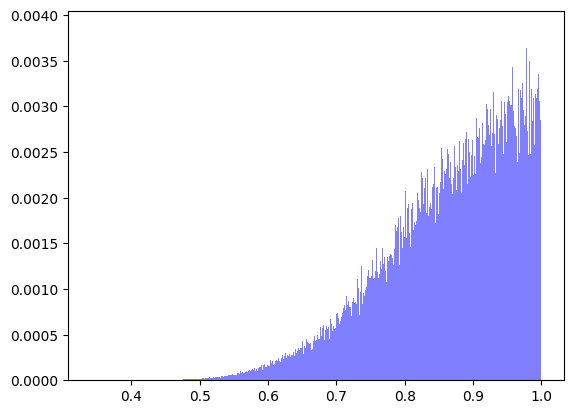

In [124]:
import matplotlib.pyplot as plt

lograts = logratios[k].logratios[:, 0]
sample = logratios[k].params[:, 0, 0]
h, bins = np.histogram(sample, weights=np.exp(lograts), density=True, bins=1000)
bin_centres = 0.5 * (bins[1:] + bins[:-1])

plt.bar(
    bin_centres,
    h / np.sum(h),
    width=bin_centres[1] - bin_centres[0],
    alpha=0.5,
    label=f'Per',
    color='b'
)

array([5.74188628e-06, 8.65890962e-06, 1.51383281e-05, 2.73963604e-05,
       5.48693360e-05, 1.18934629e-04, 2.63761173e-04, 5.92618584e-04,
       1.54302137e-03, 4.00289510e-03, 1.02370866e-02, 2.39700431e-02,
       4.66001261e-02, 8.53994309e-02, 1.19935905e-01, 1.40380053e-01,
       1.39488712e-01, 1.35042996e-01, 1.09047234e-01, 8.20610459e-02,
       5.12087976e-02, 2.89762850e-02, 1.32305131e-02, 5.04786112e-03,
       1.75927040e-03, 6.11198615e-04, 2.16181092e-04, 9.65088174e-05,
       4.04051442e-05, 1.73111439e-05])

In [106]:
lower_2_5_x_value

0.5880787

In [69]:
# Function to apply a style
def highlight_max(s):
    numeric_s = pd.to_numeric(s, errors='coerce')
    is_max = s == numeric_s.max()
    return ['background-color: rgba(255, 0, 0, 0.5)' if v else '' for v in is_max]
def highlight_min(s):
    numeric_s = pd.to_numeric(s, errors='coerce')
    is_min = s == numeric_s.min()
    return ['background-color: rgba(0, 255, 0, 0.5)' if v else '' for v in is_min]

## 
df_auc = df_val[df_val['metric']=='auc'].drop(columns='metric').set_index('feature')
df_loss = df_val[df_val['metric']=='loss'].drop(columns='metric').set_index('feature')

# Applying the style to the DataFrame
styled_df = df_auc.style.apply(highlight_max, axis=1).format("{:.3f}")

styled_df

KeyError: 'metric'

In [ ]:
df_auc.mean()

unet              0.736322
unet_attention    0.734398
unet_pruned5      0.740520
unet_pruned10     0.737922
dtype: float64

In [ ]:
# Applying the style to the DataFrame
styled_df = df_val[df_val['metric']=='loss'].style.apply(highlight_min, axis=1).format({
    'unet': "{:.3f}",
    'unet_attention': "{:.3f}",
    'unet_pruned5': "{:.3f}",
    'unet_pruned10' : "{:.3f}"
    })
styled_df

,feature,metric,unet,unet_attention,unet_pruned5,unet_pruned10
0,mass_ratio,loss,-0.282,-0.257,-0.275,-0.246
1,chirp_mass,loss,-0.448,-0.403,-0.415,-0.428
2,luminosity_distance,loss,-0.444,-0.400,-0.411,-0.394
18,dec,loss,-0.496,-0.480,-0.519,-0.506
19,ra,loss,-0.520,-0.468,-0.501,-0.509
20,psi,loss,-0.175,-0.177,-0.231,-0.217
21,geocent_time,loss,-0.515,-0.545,-0.511,-0.565
22,theta_jn,loss,-0.352,-0.343,-0.386,-0.391
23,phase,loss,0.000,0.000,-0.000,0.000
24,tilt_1,loss,-0.243,-0.240,-0.226,-0.221


In [ ]:
for k,v in names.items():
    
    select_max_timestep += f"""{k} AS (
        SELECT tag, step, value
        FROM df_{k}
        WHERE step = (
            SELECT MAX(step) 
            FROM df_{k} 
            WHERE tag LIKE 'val_loss_feature%'
            ) 
            AND (tag LIKE 'val_loss_feature%' OR tag LIKE 'val_auc_feature%')
        ),"""

query = select_max_timestep[:-1] + f"""




with duckdb.connect(database=':memory:') as conn:
    df_val = conn.execute(query).df()
    

ParserException: Parser Error: Duplicate CTE name "unet"

In [ ]:
import numpy as np
import pickle

def kl_divergence(P, Q):
    P = np.asarray(P)
    Q = np.asarray(Q)
    P = np.where(P == 0, 1e-10, P)
    Q = np.where(Q == 0, 1e-10, Q)
    return np.sum(P * np.log(P / Q))

def js_divergence(P, Q):
    P = np.asarray(P)
    Q = np.asarray(Q)
    M = 0.5 * (P + Q)
    return 0.5 * kl_divergence(P, M) + 0.5 * kl_divergence(Q, M)
   

def get_posterior_distributions(logratio_file, num_bins=500):
    
    with open(logratio_file, 'rb') as f:
        logratio_data = pickle.load(f)
    
    bounds_prior = pd.read_table(f'priors.txt', sep=',', header=None, index_col=None)
    
    num_params = logratio_data.logratios.shape[1]
    histo_data = np.zeros((num_params, 2, num_bins))
    
    for p_id in range(num_params):
        logratios = logratio_data.logratios[:, p_id]
        sample = logratio_data.params[:, p_id, 0]
        
        bin_edges = np.linspace(bounds_prior.loc[p_id][1], bounds_prior.loc[p_id][2], num_bins+1)
        h, bins = np.histogram(sample, weights=np.exp(logratios), density=True, bins=bin_edges)
        bin_centres = 0.5 * (bins[1:] + bins[:-1])
    
        histo_data[p_id,0] = bin_centres
        histo_data[p_id,1] = h
        
    return histo_data

In [ ]:
logratio_file = 'logratios/Benchmark/logratios_R8'
histo_data = get_posterior_distributions(logratio_file)

<BarContainer object of 1000 artists>

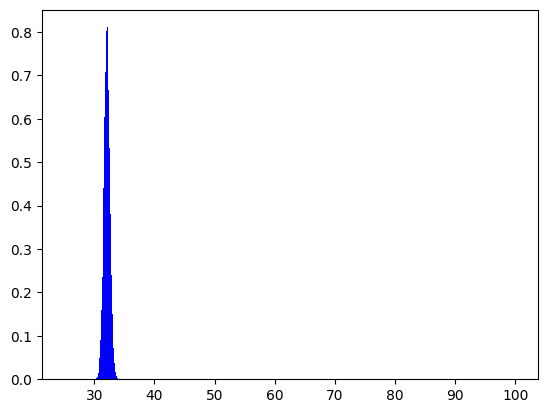

In [ ]:
import matplotlib.pyplot as plt

pid = 1

plt.bar(
    histo_data[pid,0],
    histo_data[pid,1],
    width=histo_data[pid,0][1] - histo_data[pid,0][0],
    color='b'
)

In [ ]:
def calc_js_divergence(logratio_file_1, logratio_file_2, num_bins=500):
    
    posterior1 = get_posterior_distributions(logratio_file_1, num_bins=num_bins)
    posterior2 = get_posterior_distributions(logratio_file_2, num_bins=num_bins)
    
    jsd_values = []
    for pid in range(posterior1.shape[0]):
        
        P = posterior1[pid,1] / posterior1[pid,1].sum()
        Q = posterior2[pid,1] / posterior2[pid,1].sum()
        
        jsd = js_divergence(P, Q)
        jsd_values.append(jsd)
        
    return jsd_values # sum(jsd_values)/len(jsd_values)


In [ ]:


for iround in range(1,9):
    logratio_file_1 = f'logratios/Benchmark/logratios_R8'
    logratio_file_2 = f'logratios/UNet_Softloss/logratios_R{iround}'

    print ( calc_js_divergence(logratio_file_1, logratio_file_2, num_bins=100) * 100 )

[0.13196417371912367, 0.32956703975028456, 0.048636562905332546, 0.0014627381095954875, 0.077626447103573, 0.014576037450186874, 0.013464522118148008, 0.007939183044334603, 0.0018133478489757797, 0.3275762534919059, 0.0822319168786109, 0.20535577122187343, 0.25053018463438276, 0.00525626537399859, 0.2738136740129712, 0.13196417371912367, 0.32956703975028456, 0.048636562905332546, 0.0014627381095954875, 0.077626447103573, 0.014576037450186874, 0.013464522118148008, 0.007939183044334603, 0.0018133478489757797, 0.3275762534919059, 0.0822319168786109, 0.20535577122187343, 0.25053018463438276, 0.00525626537399859, 0.2738136740129712, 0.13196417371912367, 0.32956703975028456, 0.048636562905332546, 0.0014627381095954875, 0.077626447103573, 0.014576037450186874, 0.013464522118148008, 0.007939183044334603, 0.0018133478489757797, 0.3275762534919059, 0.0822319168786109, 0.20535577122187343, 0.25053018463438276, 0.00525626537399859, 0.2738136740129712, 0.13196417371912367, 0.32956703975028456, 0.0

1.0